# Feb 18th, 2022 (upsample bold; corr timeseries)

**Motivation**: Find segments that are longer than 10 seconds uninterrupted (due to frame censoring) and for which bold and ca are highly correlated. **Update Feb 19th**: very brief CCA. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## How to upsample (infer from STIM times)

In [2]:
mice = Mice(128)
mice.setup_func_data('led')
df_ca = mice.load_stim_times('ca2')
df_bold = mice.load_stim_times('bold-lite')

In [3]:
key = 'sub-SLC06_ses-2_run-6'
stim_ca = df_ca.loc[df_ca['key'] == key, 'stim'].values
stim_bold = df_bold.loc[df_bold['key'] == key, 'stim'].values

times_ca = np.where(stim_ca)[0]
times_bold = np.where(stim_bold)[0]

In [4]:
times_bold

array([ 10,  11,  12,  13,  14,  70,  71,  72,  73,  74, 130, 131, 132,
       133, 134, 190, 191, 192, 193, 194, 250, 251, 252, 253, 254, 310,
       311, 312, 313, 314, 370, 371, 372, 373, 374, 430, 431, 432, 433,
       434, 490, 491, 492, 493, 494, 550, 551, 552, 553, 554])

In [5]:
times_ca

array([ 105,  106,  107,  108,  109,  110,  111,  112,  113,  114,  115,
        116,  117,  118,  119,  120,  121,  122,  123,  124,  125,  126,
        127,  128,  129,  130,  131,  132,  133,  134,  135,  136,  137,
        138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
        149,  150,  151,  152,  705,  706,  707,  708,  709,  710,  711,
        712,  713,  714,  715,  716,  717,  718,  719,  720,  721,  722,
        723,  724,  725,  726,  727,  728,  729,  730,  731,  732,  733,
        734,  735,  736,  737,  738,  739,  740,  741,  742,  743,  744,
        745,  746,  747,  748,  749,  750,  751,  752, 1305, 1306, 1307,
       1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318,
       1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329,
       1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340,
       1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351,
       1352, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914,
       1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 3105, 3106,
       3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117,
       3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128,
       3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139,
       3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150,
       3151, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713,
       3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724,
       3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735,
       3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746,
       3747, 3748, 3749, 3750, 3751, 4304, 4305, 4306, 4307, 4308, 4309,
       4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320,
       4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331,
       4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342,
       4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4904, 4905,
       4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916,
       4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927,
       4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938,
       4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949,
       4950, 4951, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512,
       5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523,
       5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534,
       5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545,
       5546, 5547, 5548, 5549, 5550, 5551])

## Prepare

In [6]:
mice = Mice(128)
mice.setup_func_data('rest')

fig_dir = pjoin(tmp_dir, 'fig_corr-timeseries')
os.makedirs(fig_dir, exist_ok=True)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.65), 'bold-lite': rocket(0.6)}

## Upsample test (CCA)

In [7]:
good_nodes = []
data_x = []
data_y = []
for key, (sub, ses, run) in mice.looper.items():
    if not (sub == 10 and ses == 1 and run != -1):
        continue
    try:
        bc = Base(mice, key=key, mode='ca2')
        bb = Base(mice, key=key, mode='bold-lite')
    except TypeError:
        print(key)
    
    nan_frames = np.isnan(bb.data).sum(0) == len(bb.data)
    good_frames = np.where(~nan_frames)[0]
    
    x_up, t_up = sp_sig.resample(
        x=bb.data[:, good_frames],
        num=len(good_frames) * 10,
        t=good_frames,
        axis=1,
    )
    good_frames_up = []
    for t in good_frames:
        good_frames_up.extend(list(range(10*t, 10*(t+1))))
    good_frames_up = np.array(good_frames_up)
    
    y = bc.data[:, good_frames_up]
    nonan = np.logical_and(
        np.isnan(x_up).sum(1) == 0,
        np.isnan(y).sum(1) == 0,
    )
    y = sp_stats.zscore(y[nonan], axis=1)
    x = sp_stats.zscore(x_up[nonan], axis=1)
    
    y_back = np_nans((len(nonan), len(good_frames_up)))
    x_back = np_nans((len(nonan), len(good_frames_up)))
    y_back[nonan] = y
    x_back[nonan] = x
    
    good_nodes.append(np.where(nonan)[0])
    data_y.append(y_back)
    data_x.append(x_back)
    
good_nodes = np.array(sorted(functools.reduce(
    lambda x, y: set(x).intersection(y), good_nodes
)))
x = np.concatenate(data_x, axis=-1)[good_nodes]
y = np.concatenate(data_y, axis=-1)[good_nodes]
x.shape, y.shape

sub-SLC10_ses-1_run-2

sub-SLC10_ses-1_run-4

sub-SLC10_ses-1_run-6

((154, 34360), (154, 34360))

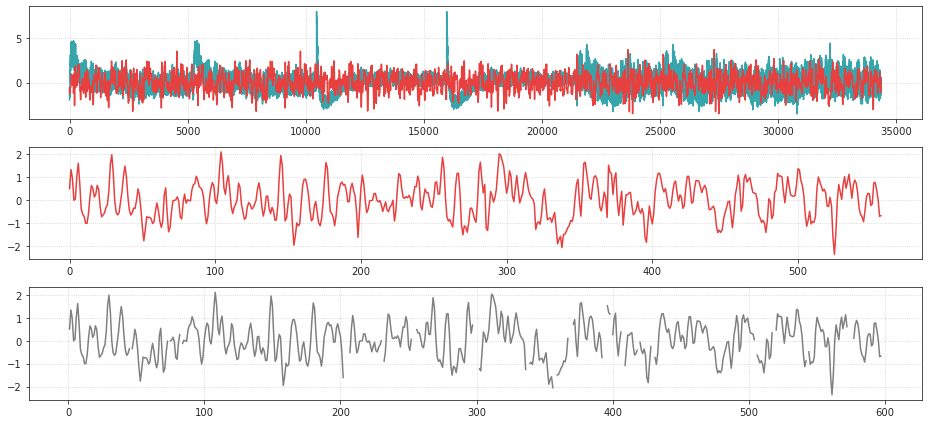

In [8]:
fig, axes = create_figure(3, 1, (13, 6))
axes[0].plot(y[15], color=pal['ca2'])
axes[0].plot(x[15], color=pal['bold-lite'])
axes[1].plot(bb.data[15][good_frames], color=pal['bold-lite'])
axes[2].plot(bb.data[15], color='Grey')
add_grid(axes)
plt.show()

In [9]:
from sklearn.cross_decomposition import CCA
top, flat = bb.load_top_flat()

In [10]:
n_components = 4
cca = CCA(n_components=n_components).fit(x.T, y.T)

In [11]:
lx = np_nans((n_components, len(bb.n2l)))
ly = np_nans((n_components, len(bc.n2l)))

lx[:, good_nodes] = cca.x_loadings_.T
ly[:, good_nodes] = cca.y_loadings_.T

In [12]:
proj_bold = bb.project_vec(lx, thres=-np.inf, add_disjoint=False)
proj_ca = bb.project_vec(ly, thres=-np.inf, add_disjoint=False)

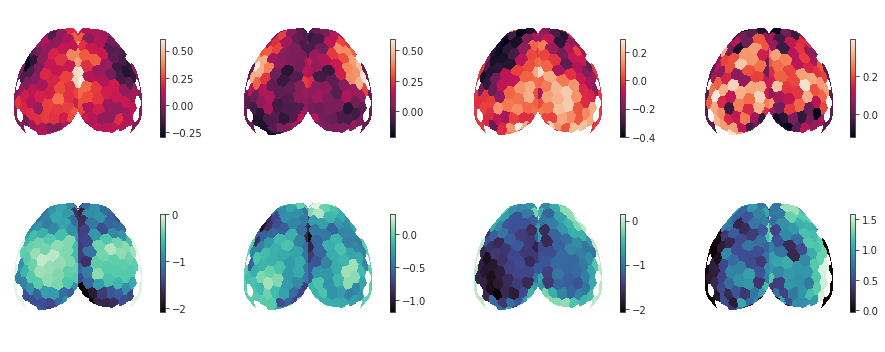

In [13]:
fig, axes = create_figure(2, 4, (13, 5), 'all', 'all')
for i in range(n_components):
    x2plt = np.ma.masked_where(top == 0, proj_bold['top'][i])
    im = axes[0, i].imshow(x2plt, cmap='rocket')
    plt.colorbar(im, ax=axes[0, i], shrink=0.6)
    
    x2plt = np.ma.masked_where(top == 0, proj_ca['top'][i])
    im = axes[1, i].imshow(x2plt, cmap='mako')
    plt.colorbar(im, ax=axes[1, i], shrink=0.6)

remove_ticks(axes)
plt.show()

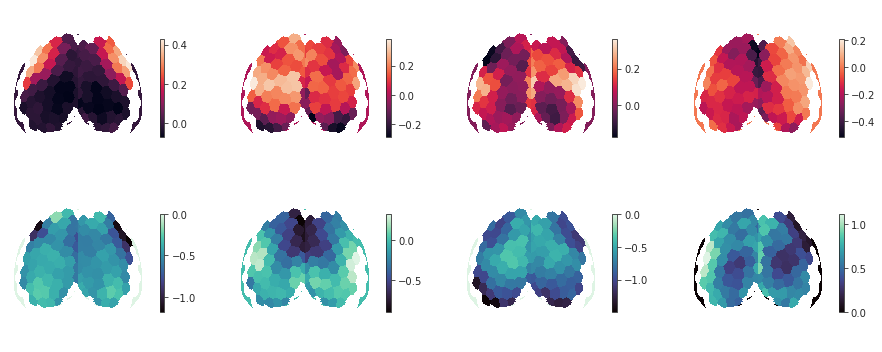

In [193]:
# Was group

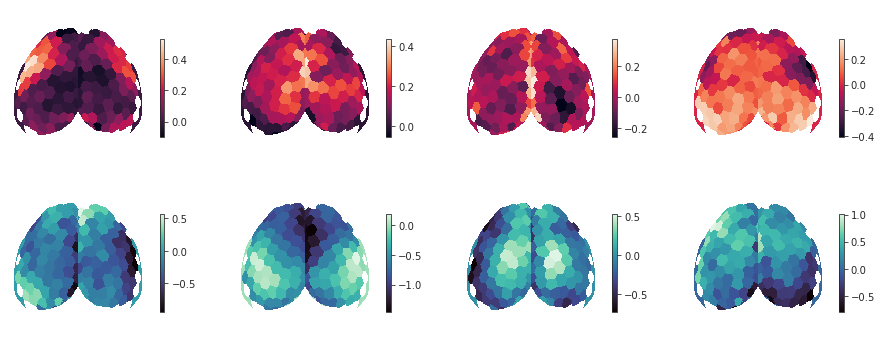

In [186]:
# Was just sub 10

## Contiguous segments

In [14]:
segments = collections.defaultdict(list)
for key in mice.bold:
    *_, run = mice.looper[key]
    if run == -1:
        continue
    bb = Base(mice, key=key, mode='bold-lite')
    nan_frames = np.isnan(bb.data).sum(0) == len(bb.data)
    clean = np.where(~nan_frames)[0]
    for k, g in itertools.groupby(enumerate(clean), lambda t: t[0] - t[1]):
        s = map(operator.itemgetter(1), g)
        segments[key].append(list(s))
segments = dict(segments)
len(segments)

114

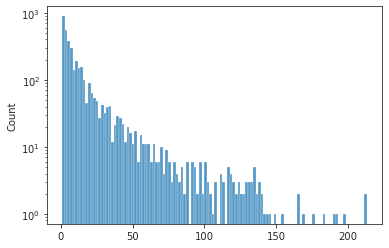

In [15]:
lens = []
for seg in segments.values():
    lens += [len(e) for e in seg]

sns.histplot(lens)
plt.yscale('log');

In [22]:
key2id = collections.defaultdict(list)
data = collections.defaultdict(list)
identifier = 0
for key, seglist in segments.items():
    sub, ses, run = mice.looper[key]
    bc = Base(mice, key=key, mode='ca2')
    bb = Base(mice, key=key, mode='bold-lite')
    for seg in seglist:
        if len(seg) < 10:
            continue
        x = bb.data[:, seg]
        a, b = min(seg), max(seg)
        seg_up = range(a * 10, b * 10)
        y = bc.data[:, seg_up]
        nonan = np.logical_and(
            np.isnan(x).sum(1) == 0,
            np.isnan(y).sum(1) == 0,
        )
        x_up = sp_sig.resample(x, len(seg_up), axis=1)

        d = sp_dist.cdist(
            XA=x_up[nonan],
            XB=y[nonan],
            metric='correlation',
        )
        best_i = np.nanargmin(np.diag(d))
        roi = np.where(nonan)[0][best_i]

        data[mice.get_key(sub)].append({
            'd': d,
            'timepoint': seg_up,
            'x': sp_stats.zscore(x_up[roi]),
            'y': sp_stats.zscore(y[roi]),
            'rho': 1 - d[best_i, best_i],
            'roi': roi,
            'key': key,
            'identifier': identifier,
        })
        key2id[key].append(identifier)
        identifier += 1
key2id = dict(key2id)
data = dict(data)
for k, dlist in data.items():
    data[k] = sorted(dlist, key=lambda e: e['rho'], reverse=True)

In [23]:
{k: len(v) for k, v in data.items()}

{
    'sub-SLC01': 165,
    'sub-SLC02': 120,
    'sub-SLC03': 169,
    'sub-SLC04': 169,
    'sub-SLC05': 138,
    'sub-SLC06': 154,
    'sub-SLC07': 145,
    'sub-SLC08': 144,
    'sub-SLC09': 152,
    'sub-SLC10': 144
}

In [24]:
ncols = 7

for k, dlist in data.items():
    nrows = int(np.ceil(len(dlist) / ncols))
    fig, axes = create_figure(
        nrows=nrows,
        ncols=ncols,
        figsize=(4 * ncols, 2.5 * nrows),
    )
    for i, d in enumerate(dlist):
        ax = axes.flat[i]
        ax.plot(d['timepoint'], d['y'], lw=1.5, color=pal['ca2'], label='ca')
        ax.plot(d['timepoint'], d['x'], lw=1.5, color=pal['bold-lite'], label='bold')
        ax.set_title(f"id = {d['identifier']}  /  roi # {d['roi']}  .  .  .  rho = {d['rho']:.2f}")
        
        if len(d['timepoint']) >= 1000:
            delta = 300
        elif 200 <= len(d['timepoint']) < 1000:
            delta = 100
        else:
            delta = 50
        xticks = [t for t in d['timepoint'] if t % delta == 0]
        xticklabels = [int(t / 10) for t in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        if (1 + i) % ncols == 0:
            ax.legend()
    add_grid(axes)
    if k in ['sub-SLC02', 'sub-SLC03', 'sub-SLC04']:
        trim_axs(axes, ncols * (nrows - 1))
    else:
        trim_axs(axes, len(dlist))
    sup = fig.suptitle(k, fontsize=30, y=1.02)
    fig.savefig(pjoin(fig_dir, f"{k}.pdf"), bbox_inches='tight')
    plt.close()

In [25]:
selected_ids = {
    'sub-SLC01': [55, 19, 65, 7, 44, 42, 146],
    'sub-SLC02': [236, 252, 269, 177, 213, 200, 211],
    'sub-SLC03': [333, 337, 388, 399, 368, 338, 386],
    'sub-SLC04': [457, 483, 586, 614, 516, 510, 541],
    'sub-SLC05': [660, 704, 754, 626, 725, 665, 661],
    'sub-SLC06': [817, 874, 827, 899, 816, 814, 900],
    'sub-SLC07': [988, 953, 986, 992, 987, 963, 1013],
    'sub-SLC08': [1098, 1140, 1080, 1093, 1090, 1178, 1086],
    'sub-SLC09': [1327, 1294, 1324, 1254, 1302, 1250, 1297],
    'sub-SLC10': [1386, 1468, 1444, 1380, 1447, 1395, 1476],
}

In [26]:
ncols, nrows = 7, 10
fig, axes = create_figure(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.1 * ncols, 2.55 * nrows),
)
for i, (k, dlist) in enumerate(data.items()):
    selected_data = [
        d for d in dlist if
        d['identifier'] in selected_ids[k]
    ]
    for j, d in enumerate(selected_data):
        ax = axes[i, j]
        ax.plot(d['timepoint'], d['y'], lw=1.5, color=pal['ca2'], label='ca')
        ax.plot(d['timepoint'], d['x'], lw=1.5, color=pal['bold-lite'], label='bold')
        ax.set_title(f"id = {d['identifier']}  /  roi # {d['roi']}  .  .  .  rho = {d['rho']:.2f}")

        if len(d['timepoint']) >= 1000:
            delta = 300
        elif 200 <= len(d['timepoint']) < 1000:
            delta = 100
        else:
            delta = 50
        xticks = [t for t in d['timepoint'] if t % delta == 0]
        xticklabels = [int(t / 10) for t in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        if (1 + j) % ncols == 0:
            ax.legend()
            axtw = ax.twinx()
            axtw.set_ylabel(k, fontsize=15, rotation=-90, labelpad=30)
            axtw.yaxis.set_label_position("right")
            axtw.set_yticks([])
add_grid(axes)
sup = fig.suptitle("Top 7 segments selected per subject", fontsize=30, y=1.02)
fig.savefig(pjoin(fig_dir, f"All-top7.pdf"), bbox_inches='tight')
plt.close()

In [27]:
window = 30

In [28]:
for i in range(int(bb.data.shape[1] / window)):
    a = window * i
    b = window * (i + 1)
    intvl = range(a, min(b, bb.data.shape[1]))
    nonan = np.isnan(bb.data[:, intvl]).sum(1) == 0
    print(i, nonan.sum())

0 0

1 174

2 0

3 0

4 0

5 0

6 0

7 0

8 0

9 0

10 0

11 0

12 0

13 0

14 0

15 174

16 174

17 174

18 174

19 174

In [29]:
a, 2

(570, 2)

<matplotlib.image.AxesImage object at 0x7ff15478daf0>

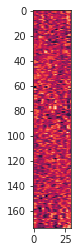

In [30]:
plt.imshow(bb.data[:, intvl])

In [31]:
bb.data[:, intvl]

array([[-0.26925401, -0.0299092 ,  0.38601569, ...,  1.32097416,
         0.54734407, -0.04153325],
       [ 0.72270039,  0.20815291, -0.60876285, ...,  1.40381221,
         1.43006267,  1.10707465],
       [ 0.06018779,  0.17192814,  0.5927646 , ...,  0.5235087 ,
         0.64778683, -0.6591093 ],
       ...,
       [ 0.1420283 ,  0.51567754, -0.10208193, ...,  0.21560763,
         0.20395543,  0.67734228],
       [ 1.47177776,  0.4704683 ,  0.01684254, ...,  1.04094641,
         1.84371676,  1.41098076],
       [ 1.10000887,  0.262034  , -0.05129808, ...,  1.62275511,
         2.05856319,  1.18308329]])

In [32]:
bc.data.shape, bb.data.shape

((174, 6000), (174, 600))

In [33]:
bold = sp_sig.resample(bb.data[13], 6000)
bold.shape

(6000,)

In [34]:
bold

array([nan, nan, nan, ..., nan, nan, nan])

## 2 x anim memship plot

In [16]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.65), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'perc': 'p10-sample',
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [17]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_base).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

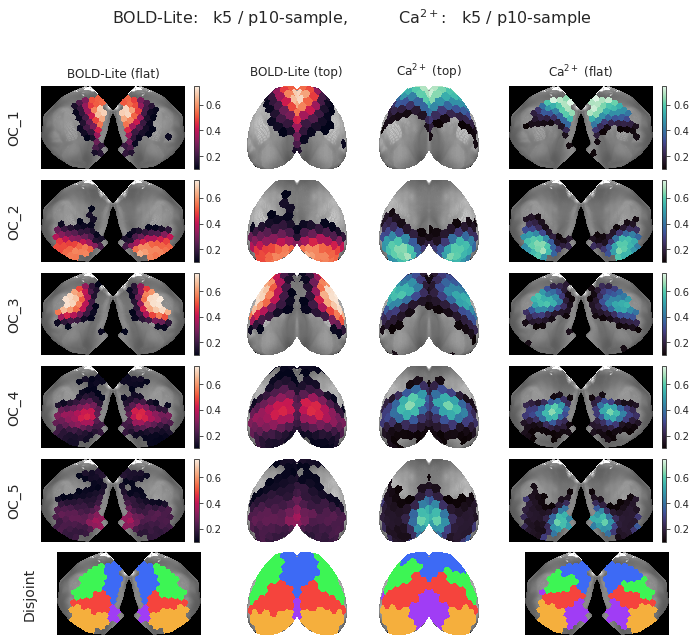

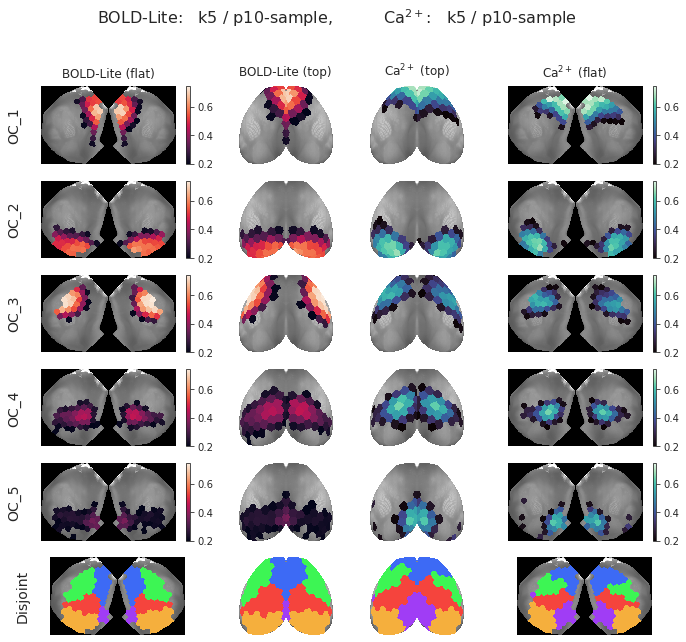

In [18]:
proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    min_thres=0.1,
    fix_cmap=True,
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

display(fig)


proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    min_thres=0.2,
    fix_cmap=True,
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

display(fig)

In [19]:
fig_dir = pjoin(tmp_dir, 'fig_membership')
os.makedirs(fig_dir, exist_ok=True)

In [20]:
for thres in [0.1, 0.15, 0.2]:
    proj_bold = gr_bold.project_vec()
    proj_ca = gr_ca.project_vec()
    fig, _ = gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        min_thres=thres,
        fix_cmap=True,
        display=False,
    )
    sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)

    fig.savefig(pjoin(fig_dir, f"thres{thres:0.2f}_group.png"), bbox_inches='tight', dpi=200)
    plt.close()
    
    for i, sub in enumerate(mice.cfg.sub_ids):
        k = mice.get_key(sub)
        proj_ca = gr_ca.project_vec(gr_ca.anim_pi[i])
        proj_bold = gr_bold.project_vec(gr_bold.anim_pi[i])

        fig, _ = gr_ca.show(
            proj_bold, proj_ca,
            labels=('BOLD-Lite', r'Ca$^{2+}$'),
            cmaps=('rocket', 'mako'),
            min_thres=thres,
            fix_cmap=True,
            display=False,
        )
        sup = f'{k}\n'
        sup += f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
        sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
        sup = fig.suptitle(sup, fontsize=16, y=1.02)

        fig.savefig(pjoin(fig_dir, f"thres{thres:0.2f}_{k}.png"), bbox_inches='tight', dpi=200)
        plt.close()